In [1]:
import torch

# Check the number of available GPUs
num_gpus = torch.cuda.device_count()
print("Number of available GPUs:", num_gpus)
# Get the properties of the first GPU
gpu_properties = torch.cuda.get_device_properties(0)
print("GPU Name:", gpu_properties.name)
print("GPU Memory:", gpu_properties.total_memory)
print("GPU Compute Capability:", gpu_properties.major, ".", gpu_properties.minor)


Number of available GPUs: 1
GPU Name: NVIDIA GeForce RTX 2060
GPU Memory: 6211633152
GPU Compute Capability: 7 . 5


In [2]:
from mss import mss
import cv2
import numpy as np
import time 
import pyautogui
from matplotlib import pyplot as plt
from gym import Env
from gym.spaces import Discrete, Box

# Building the Environment

In [75]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(1, 75, 200), dtype=np.uint8)
        self.action_space = Discrete(3)
        self.cap = mss()
        self.game_location = {"top": 110, "left": 3220, "width": 600, "height": 150}
        self.done_location = {"top": 160, "left": 3433, "width": 1, "height": 1}

    def step(self, action):
        # Action key - 0 = Space, 1 = Down, 2 = No Action
        action_map = {0: 'space', 1: 'down', 2: 'no action'}
        if action != 2:
            pyautogui.press(action_map[action])

        # Checking whether the game is done
        done = self.get_done()
        # Get the next observation
        observation = self.get_observation()
        # Calculate the reward
        reward = 1
        # Info Dictionary
        info = {}

        return observation, reward, done, info

    def reset(self):
        time.sleep(1)
        pyautogui.click(x=3420, y=150)
        pyautogui.press('space')
        return self.get_observation()


    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
    
    def close(self):
        cv2.destroyAllWindows()

    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (300, 75))
        channel = np.reshape(resized, (1, 75, 300))
        return channel

    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))[0,0,:3]

        # Valid done color
        color1 = np.array([172, 172, 172])
        
        # Apply OCR to the done text
        done = False
        if np.array_equal(done_cap, color1):
            done = True

        return done

# Tests the Environment

<class 'numpy.ndarray'>


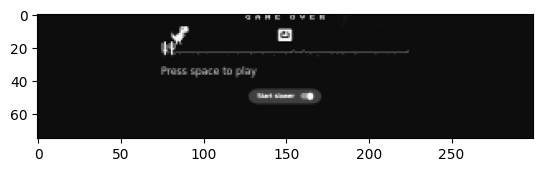

In [76]:
env = WebGame()
obs=env.get_observation()[0]
print(type(obs))
plt.imshow(obs, cmap='gray')

In [79]:
done= env.get_done()
print(done)

True


In [6]:
# for episode in range(10):
#     obs = env.reset()
#     done = False
#     total_reward = 0

#     while not done:
#         action = env.action_space.sample()
#         next_obs, reward, done, info = env.step(action)
#         env.render()
#         total_reward += reward
    
#     print('Episode: {} Total Reward: {}'.format(episode, total_reward))

# Building the Model

### Create Callback

In [7]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker 

In [8]:
env_checker.check_env(env)
time.sleep(10)

In [9]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [10]:
CHECKPOINT_PATH = './train/'
LOG_PATH = './logs/'

In [11]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_PATH)

### Build the model

In [12]:
from stable_baselines3 import DQN

In [13]:
model = DQN('CnnPolicy', env, verbose=1, tensorboard_log=LOG_PATH, device='cuda',
            buffer_size=100000, learning_starts=1000, batch_size=32)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [14]:
model.learn(total_timesteps=20000, callback=callback)

Logging to ./logs/DQN_7
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 63       |
|    ep_rew_mean      | 63       |
|    exploration_rate | 0.88     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 10       |
|    time_elapsed     | 23       |
|    total_timesteps  | 252      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 64.8     |
|    ep_rew_mean      | 64.8     |
|    exploration_rate | 0.754    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 10       |
|    time_elapsed     | 47       |
|    total_timesteps  | 518      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 69.2     |
|    ep_rew_mean      | 69.2     |
|    exploration_rate | 0.606    |
| time/               |        

KeyboardInterrupt: 

# Test the Model

In [80]:
# Play the game
for episode in range(10):
    obs = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        total_reward += rewar d
    
    print('Episode: {} Total Reward: {}'.format(episode, total_reward))

Episode: 0 Total Reward: 46
Episode: 1 Total Reward: 45


KeyboardInterrupt: 